<a href="https://colab.research.google.com/github/sathwikreddykatla/tutorial/blob/master/3_user_NOMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0: Loss = 0.8828964233398438
Epoch 10: Loss = 0.5151137113571167
Epoch 20: Loss = 0.5247091054916382
Epoch 30: Loss = 0.45594608783721924
Epoch 40: Loss = 0.38516321778297424
Epoch 50: Loss = 0.35282832384109497
Epoch 60: Loss = 0.374341756105423
Epoch 70: Loss = 0.3023999333381653
Epoch 80: Loss = 0.2931509017944336
Epoch 90: Loss = 0.28919947147369385
Epoch 100: Loss = 0.27834630012512207
Epoch 110: Loss = 0.20291943848133087
Epoch 120: Loss = 0.2387382686138153
Epoch 130: Loss = 0.25436845421791077
Epoch 140: Loss = 0.21978025138378143
Epoch 150: Loss = 0.22908219695091248
Epoch 160: Loss = 0.16835713386535645
Epoch 170: Loss = 0.2202589511871338
Epoch 180: Loss = 0.17104150354862213
Epoch 190: Loss = 0.22524462640285492
Epoch 200: Loss = 0.25245028734207153
Epoch 210: Loss = 0.18140645325183868
Epoch 220: Loss = 0.15704478323459625
Epoch 230: Loss = 0.15601879358291626
Epoch 240: Loss = 0.1503632813692093
Epoch 250: Loss = 0.1114901602268219
Epoch 260: Loss = 0.16211210191249

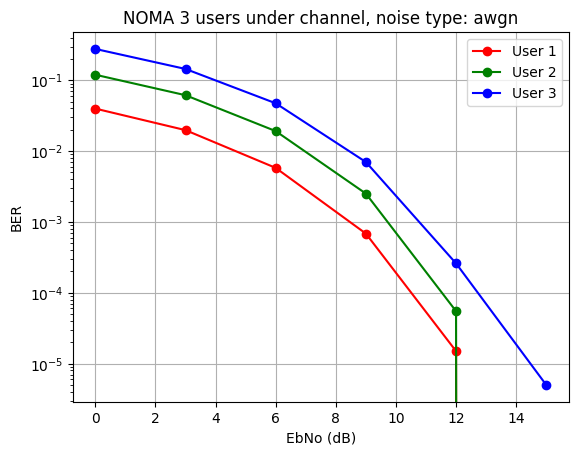

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, models
from scipy.stats import levy_stable

# Parameters
epsilon = 0.01  # CSI error variance
EbNodB = list(np.linspace(0, 15, 6))
num_bits_train = 200
num_bits_test = 200000
noise_type = 'awgn'  # t-dist, stable-dist, awgn, radar

vv = 5  # t-distribution scale
radar_prob = 0.05
radar_power_factor = 4
alpha, beta = 1.8, -0.5

# Hyperparameters
snr_train_db = 6
learning_rate = 0.001
batch_size = 50
epochs = 1000
act_func = tf.nn.relu

c1 = np.sqrt(16)  # power allocation factor
c2 = np.sqrt(4)  # power allocation factor
h = 1

# Build model
def build_decoder(input_shape, units):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(units[0], activation=act_func),
        layers.Dense(units[1], activation=act_func),
        layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    return model

# Initialize decoders for each user
decoder1 = build_decoder((1,), [16, 8])
decoder2 = build_decoder((2,), [24, 12])  # Input: concatenation of y and p1
decoder3 = build_decoder((3,), [32, 16])  # Input: concatenation of y, p1, and p2

# Optimizer and loss
loss_fn = losses.MeanSquaredError()
optimizer = optimizers.Adam(learning_rate)

# Data generation function
def generate_data(num_bits, noise_std, h):
    bits1 = np.random.binomial(n=1, p=0.5, size=num_bits)
    bits2 = np.random.binomial(n=1, p=0.5, size=num_bits)
    bits3 = np.random.binomial(n=1, p=0.5, size=num_bits)

    x1 = 2 * bits1 - 1
    x2 = 2 * bits2 - 1
    x3 = 2 * bits3 - 1
    x = x3 + c2 * x2 + c1 * x1

    if noise_type == 'awgn':
        noise = noise_std * np.random.normal(0, 1, x.shape)
    elif noise_type == 't-dist':
        noise = noise_std * np.sqrt((vv - 2) / vv) * np.random.standard_t(vv, size=x.shape)
    elif noise_type == 'radar':
        add_pos = np.random.choice([0.0, 1.0], x.shape, p=[1 - radar_prob, radar_prob])
        corrupted_signal = radar_power_factor * np.random.standard_normal(size=x.shape) * add_pos
        noise = noise_std * (np.random.normal(0, 1, x.shape) + corrupted_signal)
    elif noise_type == 'stable-dist':
        noise = noise_std * levy_stable.rvs(alpha, beta, size=x.shape)

    y = h * x + noise
    y_ = np.reshape(y, (len(y), 1))
    s1_ = np.reshape(bits1, (len(y), 1))
    s2_ = np.reshape(bits2, (len(y), 1))
    s3_ = np.reshape(bits3, (len(y), 1))
    return y_, s1_, s2_, s3_, bits3

# Fetch a batch of data for training
def fetch_batch(epoch, batch_index, batch_size, y_, s1_, s2_, s3_):
    train_size = len(y_)
    np.random.seed(epoch * (train_size // batch_size) + batch_index)
    indices = np.random.randint(train_size, size=batch_size)
    return y_[indices], s1_[indices], s2_[indices], s3_[indices]

# Training loop
for epoch in range(epochs):
    y_, s1_, s2_, s3_, _ = generate_data(num_bits_train, np.sqrt(1 / (10 ** (snr_train_db / 10.0))), h)

    for batch_index in range(len(y_) // batch_size):
        _y, _s1, _s2, _s3 = fetch_batch(epoch, batch_index, batch_size, y_, s1_, s2_, s3_)

        with tf.GradientTape() as tape:
            # Forward pass through decoders
            p1 = decoder1(_y, training=True)
            z2 = tf.concat([_y, p1], axis=-1)
            z2 = tf.reshape(z2, [batch_size, 2])
            p2 = decoder2(z2, training=True)
            z3 = tf.concat([z2, p2], axis=-1)
            z3 = tf.reshape(z3, [batch_size, 3])
            p3 = decoder3(z3, training=True)

            # Compute loss for each user
            loss1 = loss_fn(_s1, p1)
            loss2 = loss_fn(_s2, p2)
            loss3 = loss_fn(_s3, p3)
            loss = loss1 + loss2 + loss3

        # Apply gradients
        grads = tape.gradient(loss, decoder1.trainable_weights + decoder2.trainable_weights + decoder3.trainable_weights)
        optimizer.apply_gradients(zip(grads, decoder1.trainable_weights + decoder2.trainable_weights + decoder3.trainable_weights))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}: Loss = {loss.numpy()}')

# Testing and evaluation loop
def recover_bits(y_, decoder1, decoder2, decoder3):
    # Decode bits for user 1
    p1 = decoder1(y_, training=False)
    bits_re1 = tf.cast(tf.greater(p1, 0.5), tf.int32).numpy().flatten()

    # Decode bits for user 2
    z2 = tf.concat([y_, tf.cast(bits_re1[:, None], tf.float32)], axis=1)
    p2 = decoder2(z2, training=False)
    bits_re2 = tf.cast(tf.greater(p2, 0.5), tf.int32).numpy().flatten()

    # Decode bits for user 3
    z3 = tf.concat([z2, p2], axis=-1)
    z3 = tf.reshape(z3, [len(y_), 3])
    p3 = decoder3(z3, training=False)
    bits_re3 = tf.cast(tf.greater(p3, 0.5), tf.int32).numpy().flatten()

    return bits_re1, bits_re2, bits_re3

# Initialize lists to store BER for each user
ber_user1 = [None] * len(EbNodB)
ber_user2 = [None] * len(EbNodB)
ber_user3 = [None] * len(EbNodB)

# Evaluate BER for each user across different EbNo values
for ii in range(len(EbNodB)):
    EbNo = 10 ** (EbNodB[ii] / 10.0)
    noise_std = np.sqrt(1 / EbNo)
    y_, s1_, s2_, s3_, bits3 = generate_data(num_bits_test, noise_std, h)

    # Recover bits for each user
    bits_re1, bits_re2, bits_re3 = recover_bits(y_, decoder1, decoder2, decoder3)

    # Calculate BER for each user
    num_errors1 = sum(bits_re1 != s1_.flatten())
    num_errors2 = sum(bits_re2 != s2_.flatten())
    num_errors3 = sum(bits_re3 != bits3)

    ber_user1[ii] = num_errors1 / num_bits_test
    ber_user2[ii] = num_errors2 / num_bits_test
    ber_user3[ii] = num_errors3 / num_bits_test

# Plot BER for all users
plt.plot(EbNodB, ber_user1, '-ro', label='User 1')
plt.plot(EbNodB, ber_user2, '-go', label='User 2')
plt.plot(EbNodB, ber_user3, '-bo', label='User 3')
plt.yscale('log')
plt.xlabel('EbNo (dB)')
plt.ylabel('BER')
plt.title(f'NOMA 3 users under channel, noise type: {noise_type}')
plt.legend()
plt.grid()
plt.show()
